# Data visualization, analysis, and prediction
Dataset from HR data ( https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists )

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

In [2]:
# list data in da folder
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

./data/aug_test.csv
./data/aug_train.csv
./data/sample_submission.csv


In [3]:
train = pd.read_csv('./data/aug_train.csv')
test = pd.read_csv('./data/aug_test.csv')
train.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


## *Features:* 
- enrollee_id : Unique ID for candidate

- city: City code

- city_ development _index : Developement index of the city (scaled)

- gender: Gender of candidate

- relevent_experience: Relevant experience of candidate

- enrolled_university: Type of University course enrolled if any

- education_level: Education level of candidate

- major_discipline :Education major discipline of candidate

- experience: Candidate total experience in years

- company_size: No of employees in current employer's company

- company_type : Type of current employer

- lastnewjob: Difference in years between previous job and current job

- training_hours: training hours completed

- target: 0 – Not looking for job change, 1 – Looking for a job change

## Dealing with missing values


In [4]:
# Check for missing values
train.isna().sum()/len(train)

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

**as we can see, most of the variables are categorical variables, and the dataset is not balanced.**

dealing with missing values can often be subjective. in this exercise, I'm going to impute missing data with forward fill

In [5]:
train["gender"] = train["gender"].fillna(method="pad")
train["enrolled_university"] = train["enrolled_university"].fillna(method="pad")
train["education_level"] = train["education_level"].fillna(method="pad")
train["education_level"] = train["education_level"].fillna(method="pad")
train["major_discipline"] = train["major_discipline"].fillna(method="pad")
train["experience"] = train["experience"].fillna(method="pad")
train["company_size"] = train["company_size"].fillna(method="pad")
train["company_type"] = train["company_type"].fillna(method="pad")
train["last_new_job"] = train["last_new_job"].fillna(method="pad")

## Data Visualization

In [6]:
# EDUCATION LEVEL
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
train_graph_temp_df = pd.DataFrame(train["education_level"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["education_level"].apply(lambda x: x/sum(train_graph_temp_df["education_level"])*100).loc[ed_order]
train_graph_temp_df = train_graph_temp_df.sort_index()

test_graph_temp_df = pd.DataFrame(test["education_level"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["education_level"].apply(lambda x: x/sum(test_graph_temp_df["education_level"])*100).loc[ed_order]
test_graph_temp_df = test_graph_temp_df.sort_index()

test_graph_temp_df

,education_level,Percentage
Graduate,1269,61.097737
High School,222,10.688493
Masters,496,23.880597
Phd,54,2.599904
Primary School,36,1.733269


[Text(0, 0, 'Graduate'),
 Text(0, 0, 'High School'),
 Text(0, 0, 'Masters'),
 Text(0, 0, 'Phd'),
 Text(0, 0, 'Primary School')]

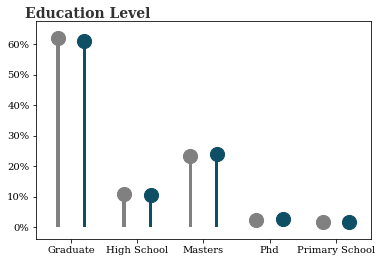

In [7]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(train_graph_temp_df.index)), height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.05)
ax.scatter(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3,s=200, color="gray")
ax.bar(np.arange(len(test_graph_temp_df.index))+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax.scatter(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3,s=200, color="#0e4f66")
ax.text(-0.5, 68.5, 'Education Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax.set_xticks(np.arange(len(train_graph_temp_df.index))+0.4 / 2)
ax.set_xticklabels(list(train_graph_temp_df.index),rotation=0)

In [8]:
# Ax1 - ENROLLED IN UNIVESITY
train_graph_temp_df = pd.DataFrame(train["enrolled_university"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(train_graph_temp_df["enrolled_university"])*100)
train_graph_temp_df = train_graph_temp_df.sort_index()

test_graph_temp_df = pd.DataFrame(test["enrolled_university"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(test_graph_temp_df["enrolled_university"])*100)
test_graph_temp_df = test_graph_temp_df.sort_index()

test_graph_temp_df

,enrolled_university,Percentage
Full time course,435,20.734032
Part time course,144,6.863680
no_enrollment,1519,72.402288


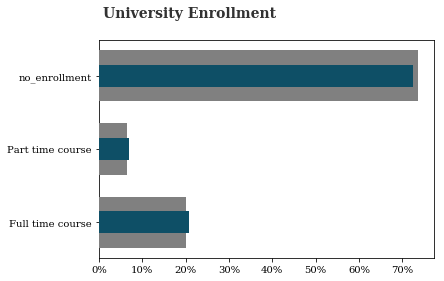

In [9]:
fig, ax = plt.subplots()
ax.text(1, 2.8, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.barh(train_graph_temp_df.index, train_graph_temp_df['Percentage'], color="gray", zorder=3, height=0.7)
ax.barh(test_graph_temp_df.index, test_graph_temp_df['Percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))

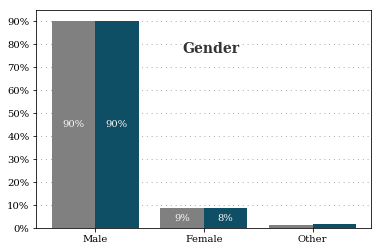

In [10]:
#GENDER 
train_graph_temp_df = pd.DataFrame(train["gender"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["gender"].apply(lambda x: x/sum(train_graph_temp_df["gender"])*100)
test_graph_temp_df = pd.DataFrame(test["gender"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["gender"].apply(lambda x: x/sum(test_graph_temp_df["gender"])*100)

x = np.arange(len(train_graph_temp_df))

fig, ax = plt.subplots()
ax.text(1, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax.set_xticks(x + 0.4 / 2)
ax.set_xticklabels(['Male','Female','Other'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    
    

Text(0.5, 0, '')

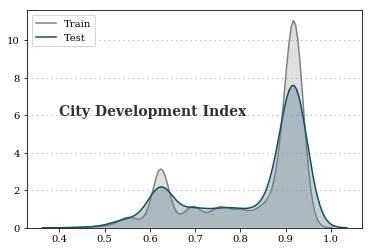

In [11]:
#CDI
train_graph_temp_df = pd.DataFrame(train["city_development_index"])
test_graph_temp_df = pd.DataFrame(test["city_development_index"])
fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train_graph_temp_df["city_development_index"], ax=ax,color="gray", shade=True, label="Train")
sns.kdeplot(test_graph_temp_df["city_development_index"], ax=ax, color="#0e4f66", shade=True, label="Test")
ax.text(0.4, 6, 'City Development Index', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax.set_ylabel('')    
ax.set_xlabel('')

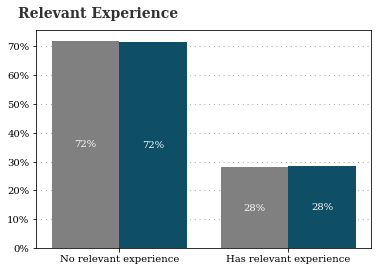

In [12]:
# EXPERIENCE
train_graph_temp_df = pd.DataFrame(train["relevent_experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(train_graph_temp_df["relevent_experience"])*100)
test_graph_temp_df = pd.DataFrame(test["relevent_experience"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(test_graph_temp_df["relevent_experience"])*100)

x = np.arange(len(train_graph_temp_df))
fig, ax = plt.subplots()
ax.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax.set_xticks(x + 0.4 / 2)
ax.set_xticklabels(['No relevant experience','Has relevant experience'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

Text(0, 0.5, '')

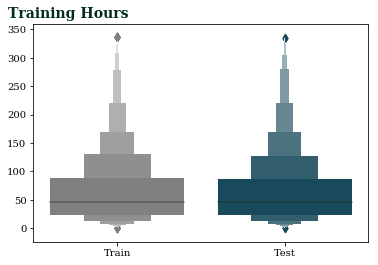

In [13]:
#TRAINING HOURS
train_graph_temp_df = pd.DataFrame(train["training_hours"])
train_graph_temp_df["TrainTest"] = "Train"
test_graph_temp_df = pd.DataFrame(test["training_hours"])
test_graph_temp_df["TrainTest"] = "Test"

fig, ax = plt.subplots()
ax.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train_graph_temp_df, test_graph_temp_df], axis=0)
sns.boxenplot(ax=ax, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax.set_xlabel("")
ax.set_ylabel("")

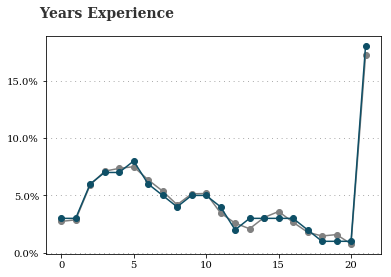

In [14]:
#EXPERIENCE YRS
train_graph_temp_df = pd.DataFrame(train["experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["experience"].apply(lambda x: x/sum(train_graph_temp_df["experience"])*100)
train_graph_temp_df['index1'] = train_graph_temp_df.index
train_graph_temp_df['index1'] = train_graph_temp_df['index1'].replace(['>20'],'21')
train_graph_temp_df['index1'] = train_graph_temp_df['index1'].replace(['<1'],'0')
train_graph_temp_df['index1']  = pd.to_numeric(train_graph_temp_df['index1'])
train_graph_temp_df = train_graph_temp_df.sort_values('index1')


test_graph_temp_df = pd.DataFrame(test["experience"].value_counts())
test_graph_temp_df["Percentage"] = round(test_graph_temp_df["experience"].apply(lambda x: x/sum(test_graph_temp_df["experience"])*100),).astype(int)

test_graph_temp_df['index1'] = test_graph_temp_df.index
test_graph_temp_df['index1'] = test_graph_temp_df['index1'].replace(['>20'],'21')
test_graph_temp_df['index1'] = test_graph_temp_df['index1'].replace(['<1'],'0')
test_graph_temp_df['index1']  = pd.to_numeric(test_graph_temp_df['index1'])
test_graph_temp_df = test_graph_temp_df.sort_values('index1')


fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.plot(train_graph_temp_df['index1'], train_graph_temp_df["Percentage"], zorder=3, color="gray", marker='o')
ax.plot(test_graph_temp_df['index1'], test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax.text(-1.5, 20.5, 'Years Experience', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

#ax.set_yticklabels(labels = ['0   ', '5%','10%','15%',"20%"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax.yaxis.set_major_locator(mtick.MultipleLocator(5))


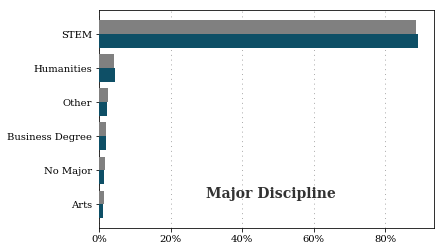

In [15]:
#MAJOR DISCIPLINE
train_graph_temp_df = pd.DataFrame(train["major_discipline"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["major_discipline"].apply(lambda x: x/sum(train_graph_temp_df["major_discipline"])*100)

test_graph_temp_df = pd.DataFrame(test["major_discipline"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["major_discipline"].apply(lambda x: x/sum(test_graph_temp_df["major_discipline"])*100)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='x', zorder=0,  dashes=(1,5))
ax.barh(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3, color="gray", height=0.4)
ax.barh(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax.text(30, 5, 'Major Discipline', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax.set_yticks(np.arange(len(test_graph_temp_df.index))+0.4 / 2)
ax.set_yticklabels(list(test_graph_temp_df.index))
ax.invert_yaxis()



## Findings:

- training set and testing set are pretty similar which is good
- 90% people in this sample are male
- 88% are STEM majored
- 60% of them have greduate degree, 30% has master degree
- more than 30% of them has 10+ yrs experiences

## let's focus on the features in training set
a couple points to look into:
1. who is looking for a new job, by gender
2. in which cities are the job seekers living
3. what similarities do they have

Text(0, 0.5, '')

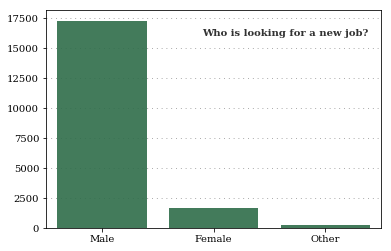

In [16]:
# Distribution
color_palette=["gray","#0e4f66"]

fig, ax = plt.subplots()
ax.text(0.9, 16000, 'Who is looking for a new job?', fontsize=10, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x=train["gender"], color="#247747", ax=ax, zorder=3,alpha=0.9)
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

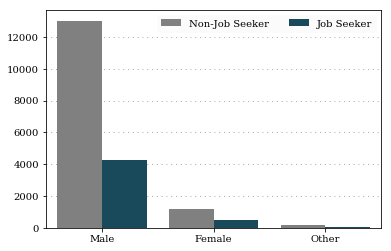

In [17]:
#by gender
fig, ax = plt.subplots()
#ax.text(-1, 11000, 'Job searching by gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x="gender", hue="target", data=train, palette=color_palette, ax=ax, zorder=3)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=2, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

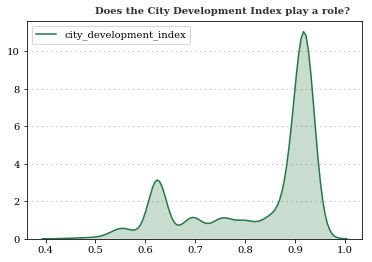

In [18]:
# CDI
fig, ax = plt.subplots()
ax.text(0.5, 12, 'Does the City Development Index play a role?', fontsize=10, fontweight='bold', fontfamily='serif', color="#323232")

ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train["city_development_index"], color="#247747", shade=True, ax=ax, zorder=3)
ax.set_xlabel("")
ax.set_ylabel("")


Text(0, 0.5, '')

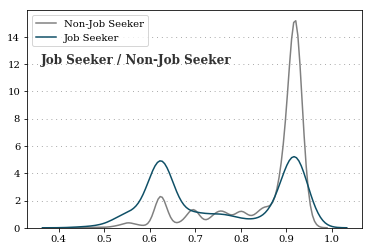

In [19]:
fig, ax = plt.subplots()
ax.text(0.36, 12, 'Job Seeker / Non-Job Seeker', fontsize=12, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train.loc[(train["target"]==0), "city_development_index"], color="gray", label="Non-Job Seeker", ax=ax)
sns.kdeplot(train.loc[(train["target"]==1), "city_development_index"], color="#0e4f66", label="Job Seeker", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")

In [20]:
###
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
job_order = ['Never', '1', '2', '3', '4', '>4']
train['count'] = 1
job_hunt_only = train[train['target']==1]
no_job_hunt_only = train[train['target']==0]

job_change = train.groupby(['education_level','last_new_job'])['experience'].sum().unstack()

job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack()
notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

notseek_job_change.columns = ['count']
seek_job_change.columns = ['count']

notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100




ed_notseek_job_change = no_job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T
ed_seek_job_change = job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T

ed_notseek_job_change.columns = ['count']
ed_seek_job_change.columns = ['count']

ed_notseek_job_change["percentage"] = ed_notseek_job_change["count"].apply(lambda x: x/sum(ed_notseek_job_change["count"])) *100
ed_seek_job_change["percentage"] = ed_seek_job_change["count"].apply(lambda x: x/sum(ed_seek_job_change["count"])) *100



In [21]:
#seek_job_change = seek_job_change.loc[job_order]
#notseek_job_change = notseek_job_change.loc[job_order]
ed_seek_job_change = ed_seek_job_change.loc[ed_order]
ed_notseek_job_change = ed_notseek_job_change.loc[ed_order]


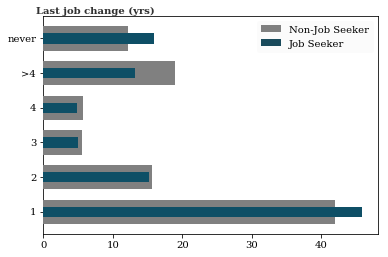

In [22]:
fig, ax = plt.subplots()
ax.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.text(-1, 5.7, 'Last job change (yrs)',fontsize=10, fontweight='bold', fontfamily='serif',color='#323232')
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=1, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')

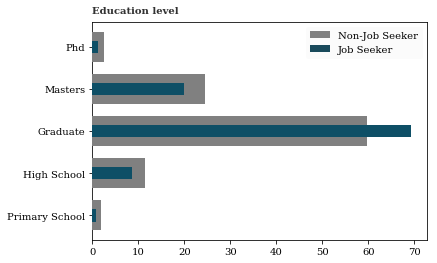

In [23]:
fig, ax = plt.subplots()
ax.barh(ed_notseek_job_change.index, ed_notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax.barh(ed_seek_job_change.index, ed_seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.text(0, 4.8, 'Education level', fontsize=10, fontweight='bold', fontfamily='serif',color='#323232')
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=1, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')

## Findings
1. the peak job seekers are in low CDI and high CDI groups
2. job seekers are more likely change job more oftern than non-job seekers
3. more job seekers in the graduate sample than non-job seekers

In [50]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Data Preparation

In [25]:
def city_code(x):
    y = x.str.split("_",expand=True)[1].astype('int64')
    return y

In [26]:
train['city'] = city_code(train['city'])

In [27]:
ord_pipe = Pipeline([
    ('ord_encode',OrdinalEncoder([
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

In [28]:
def null_fill(x):
    return x.fillna('Unknown',inplace=True)
null_fill(train)

In [29]:
ord_pipe

Pipeline(steps=[('ord_encode',
                 OrdinalEncoder(categories=[['Unknown', 'Primary School',
                                             'High School', 'Graduate',
                                             'Masters', 'Phd'],
                                            ['Unknown', '<1', '1', '2', '3',
                                             '4', '5', '6', '7', '8', '9', '10',
                                             '11', '12', '13', '14', '15', '16',
                                             '17', '18', '19', '20', '>20'],
                                            ['Unknown', '<10', '10/49', '50-99',
                                             '100-500', '500-999', '1000-4999',
                                             '5000-9999', '10000+'],
                                            ['Unknown', '1', '2', '3', '4',
                                             '>4', 'never']]))])

In [30]:
ord_column = ['education_level','experience','company_size','last_new_job']
card_column = ['gender','relevent_experience','enrolled_university','major_discipline','company_type'] 

In [31]:
def encoder(df,ord_column,card_column):
    ord_pipe.fit(df[ord_column])
    df[ord_column] = ord_pipe.transform(df[ord_column])
    df = pd.get_dummies(df,columns=card_column)
    return df

In [32]:
train = encoder(train,ord_column,card_column)

In [33]:
train.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,count,...,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,8949,103,0.920,3.0,22.0,0.0,1.0,36,1.0,1,...,0,0,1,0,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0.0,1,...,0,0,1,0,0,0,0,0,1,0
2,11561,21,0.624,3.0,6.0,3.0,6.0,83,0.0,1,...,0,0,1,0,0,0,0,0,1,0
3,33241,115,0.789,3.0,1.0,3.0,6.0,52,1.0,1,...,0,0,0,0,0,0,0,0,1,0
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0.0,1,...,0,0,1,0,1,0,0,0,0,0


# Modeling

In [34]:
X = train.drop(columns=['enrollee_id','target'])
y = train.target

In [37]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [7] are constant.
  UserWarning)


In [38]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [7] are constant.
  UserWarning)


In [39]:
X_new.columns

Index(['city', 'city_development_index', 'experience', 'gender_Female',
       'gender_Male', 'relevent_experience_Has relevent experience',
       'relevent_experience_No relevent experience',
       'enrolled_university_Full time course',
       'enrolled_university_no_enrollment',
       'company_type_Early Stage Startup'],
      dtype='object')

In [40]:
X_new.head()

,city,city_development_index,experience,gender_Female,gender_Male,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_no_enrollment,company_type_Early Stage Startup
0,103,0.920,22.0,0,1,1,0,0,1,0
1,40,0.776,16.0,0,1,0,1,0,1,0
2,21,0.624,6.0,0,1,0,1,1,0,0
3,115,0.789,1.0,0,1,0,1,1,0,0
4,162,0.767,22.0,0,1,1,0,0,1,0


In [41]:
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15326, 10), (3832, 10), (15326,), (3832,))

In [42]:
num_pipe = Pipeline([
    ('scaler',StandardScaler())
])

In [43]:
num_column = ['city','city_development_index']

In [44]:
def transform_scaling(X,num_column):
    num_pipe.fit(X[num_column])
    X[num_column] = num_pipe.transform(X[num_column])
    return X

In [45]:
X_train = transform_scaling(X_train,num_column)
X_test = transform_scaling(X_test,num_column)

In [46]:
X_train.head()

,city,city_development_index,experience,gender_Female,gender_Male,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_no_enrollment,company_type_Early Stage Startup
17855,-1.276746,-1.672102,11.0,0,1,1,0,0,1,0
17664,0.489526,0.734358,6.0,0,1,0,1,0,1,0
13404,-0.652089,0.539240,13.0,0,1,1,0,0,1,0
13366,0.489526,0.734358,6.0,0,1,1,0,0,1,0
15670,-0.285910,0.205913,6.0,1,0,1,0,1,0,0


In [54]:
models = Pipeline([
    ('clf', None), 
])

search = GridSearchCV(
    models, 
    cv=3, 
    return_train_score=False, 
    scoring=['accuracy', 'recall', 'f1'],
    refit = 'f1',
    param_grid={
        'clf': [GaussianNB(),DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]        
})

In [55]:
search.fit(X_train,y_train)

print('Best model:', search.best_params_)
model_comparison = pd.DataFrame(search.cv_results_)
model_comparison

Best model: {'clf': GaussianNB()}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,...,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.006322,0.000643,0.008429,0.000594,GaussianNB(),{'clf': GaussianNB()},0.709924,0.719906,0.721809,0.717213,...,0.501952,0.461681,0.028482,1,0.426471,0.443840,0.475065,0.448458,0.020105,1
1,0.019308,0.002895,0.011304,0.003428,DecisionTreeClassifier(),{'clf': DecisionTreeClassifier()},0.740849,0.741241,0.727095,0.736395,...,0.353630,0.359581,0.006610,3,0.410508,0.410348,0.393913,0.404923,0.007785,3
2,0.554021,0.014102,0.078275,0.000803,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.752398,0.747700,0.740995,0.747031,...,0.374707,0.377912,0.007289,2,0.434004,0.426346,0.420499,0.426950,0.005530,2
3,0.070641,0.000797,0.006806,0.000124,LogisticRegression(),{'clf': LogisticRegression()},0.764925,0.759640,0.769969,0.764844,...,0.264637,0.248889,0.013899,4,0.343357,0.326754,0.365893,0.345335,0.016039,4


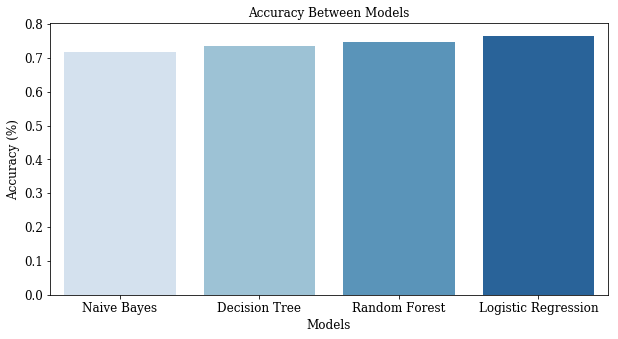

In [56]:
model_comparison['model'] = ['Naive Bayes','Decision Tree', 'Random Forest', 'Logistic Regression']

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot('model', 'mean_test_accuracy', data=model_comparison, capsize=.05, palette='Blues', ci=None)
ax.set_xlabel("Models",fontsize=12)
ax.set_ylabel("Accuracy (%)",fontsize=12)
ax.tick_params(labelsize=12)
ax.axes.set_title("Accuracy Between Models", fontsize=12)

plt.show()

In [61]:
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
prediction_dt = tree.predict(X_test)
print("The Accuracy Score of Logistic Regression is: {}%".format(accuracy_score(y_test, prediction_dt)*100))
print("The Confusion Matrix for Logistic Regression is: \n{}\n".format(confusion_matrix(y_test, prediction_dt)))
print('\n')
print(classification_report(y_test, prediction_dt))

The Accuracy Score of Logistic Regression is: 72.44258872651356%
The Confusion Matrix for Logistic Regression is: 
[[2593  284]
 [ 772  183]]



              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83      2877
         1.0       0.39      0.19      0.26       955

    accuracy                           0.72      3832
   macro avg       0.58      0.55      0.54      3832
weighted avg       0.68      0.72      0.69      3832



In [60]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
prediction_rf = forest.predict(X_test)

print("The Accuracy Score of Logistic Regression is: {}%".format(accuracy_score(y_test, prediction_rf)*100))
print("The Confusion Matrix for Logistic Regression is: \n{}\n".format(confusion_matrix(y_test, prediction_rf)))
print('\n')
print(classification_report(y_test, prediction_rf))


The Accuracy Score of Logistic Regression is: 74.26931106471815%
The Confusion Matrix for Logistic Regression is: 
[[2661  216]
 [ 770  185]]



              precision    recall  f1-score   support

         0.0       0.78      0.92      0.84      2877
         1.0       0.46      0.19      0.27       955

    accuracy                           0.74      3832
   macro avg       0.62      0.56      0.56      3832
weighted avg       0.70      0.74      0.70      3832



In [59]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter = 300)
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)
print("The Accuracy Score of Logistic Regression is: {}%".format(accuracy_score(y_test, y_pred_log)*100))
print("The Confusion Matrix for Logistic Regression is: \n{}\n".format(confusion_matrix(y_test, y_pred_log)))
print('\n')
print(classification_report(y_test, y_pred_log))


The Accuracy Score of Logistic Regression is: 76.90501043841336%
The Confusion Matrix for Logistic Regression is: 
[[2705  172]
 [ 713  242]]



              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86      2877
         1.0       0.58      0.25      0.35       955

    accuracy                           0.77      3832
   macro avg       0.69      0.60      0.61      3832
weighted avg       0.74      0.77      0.73      3832

